In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from sklearn.metrics import precision_recall_fscore_support

In [2]:
base_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

In [3]:
class_specific_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.5),          
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
dataset_path = r'Danger Of Extinction'
Dataset = datasets.ImageFolder(root=dataset_path)

class_names=Dataset.classes

print(class_names)
print("Class to Index Mapping:", dataset.class_to_idx)

class_specific_indices = [dataset.class_to_idx['Jaguars'], dataset.class_to_idx['cheetahs']]
print("Class-Specific Indices:", class_specific_indices)

['African_Elephant', 'Amur_Leopard', 'Arctic_Fox', 'Chimpanzee', 'Jaguars', 'Lion', 'Orangutan', 'Panda', 'Panthers', 'Rhino', 'cheetahs']
Class to Index Mapping: {'African_Elephant': 0, 'Amur_Leopard': 1, 'Arctic_Fox': 2, 'Chimpanzee': 3, 'Jaguars': 4, 'Lion': 5, 'Orangutan': 6, 'Panda': 7, 'Panthers': 8, 'Rhino': 9, 'cheetahs': 10}
Class-Specific Indices: [4, 10]


In [32]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, class_specific, base_transform, specific_transform):
        
        self.dataset = dataset
        self.class_specific = class_specific
        self.base_transform = base_transform
        self.specific_transform = specific_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        if label in self.class_specific:
            img = self.specific_transform(img)
        else:
            img = self.base_transform(img)
        
        return img, label


In [47]:
custom_dataset = CustomDataset(
    dataset=dataset,
    class_specific=class_specific_indices,
    base_transform=base_transform,
    specific_transform=class_specific_transform
)


In [48]:
train_size = int(0.7 * len(custom_dataset)) 
val_size = int(0.15 * len(custom_dataset))   
test_size = len(custom_dataset) - train_size - val_size  

In [49]:
train_data, val_data, test_data = random_split(custom_dataset, [train_size, val_size, test_size])

In [50]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [51]:
model = models.resnet50(weights=True)

In [52]:
model.fc = nn.Linear(model.fc.in_features, len(class_names))

In [53]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [54]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
num_epochs = 15  
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() 

        # forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch [1/15], Loss: 0.9804, Accuracy: 69.24%
Epoch [2/15], Loss: 0.5942, Accuracy: 80.74%
Epoch [3/15], Loss: 0.4371, Accuracy: 85.61%
Epoch [4/15], Loss: 0.3324, Accuracy: 88.94%
Epoch [5/15], Loss: 0.3308, Accuracy: 89.51%
Epoch [6/15], Loss: 0.2655, Accuracy: 91.08%
Epoch [7/15], Loss: 0.2292, Accuracy: 92.02%
Epoch [8/15], Loss: 0.2641, Accuracy: 91.12%
Epoch [9/15], Loss: 0.2016, Accuracy: 92.99%
Epoch [10/15], Loss: 0.1485, Accuracy: 95.46%
Epoch [11/15], Loss: 0.1563, Accuracy: 94.58%
Epoch [12/15], Loss: 0.1558, Accuracy: 94.49%
Epoch [13/15], Loss: 0.1616, Accuracy: 94.67%
Epoch [14/15], Loss: 0.0999, Accuracy: 96.45%
Epoch [15/15], Loss: 0.1216, Accuracy: 95.66%


In [57]:
torch.save(model, "Transfer_learning_model2_resnet50.pth")


In [58]:
model.eval()  
val_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()


In [59]:
val_loss /= len(val_loader)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.3819, Validation Accuracy: 89.20%


In [60]:
model.eval() 
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

In [61]:
test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.3041, Test Accuracy: 90.86%


In [62]:
def show_random_test_prediction(model, test_data, class_names):
    model.eval()  

    random_idx = random.randint(0, len(test_data) - 1)
    image, true_label = test_data[random_idx]

    image_tensor = image.unsqueeze(0).to(device)  

    with torch.no_grad(): 
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)

    image_np = image.cpu().numpy().transpose((1, 2, 0)) 
    image_np = np.clip(image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1) 

    plt.imshow(image_np)
    plt.title(f"Predicted: {class_names[predicted_label.item()]}, Actual: {class_names[true_label]}")
    plt.axis("off")
    plt.show()

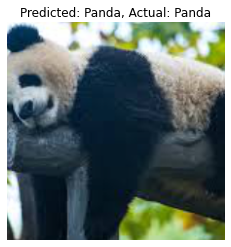

In [86]:
show_random_test_prediction(model, test_data, class_names)

In [64]:
val_loss = 0.0
val_correct = 0
val_total = 0
all_val_labels = []
all_val_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(predicted.cpu().numpy())

val_loss /= len(val_loader)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

precision, recall, f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted')

print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")

test_loss = 0.0
test_correct = 0
test_total = 0
all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Store the true labels and predictions
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_preds, average='weighted')

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Validation Loss: 0.3638, Validation Accuracy: 89.40%
Validation Precision: 0.8988
Validation Recall: 0.8940
Validation F1-Score: 0.8941
Test Loss: 0.2856, Test Accuracy: 91.58%
Test Precision: 0.9184
Test Recall: 0.9158
Test F1-Score: 0.9160
